## IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
input_dir = "data/olist_order_reviews_dataset.csv"

# HYPERPARAMETERS
RANDOM_STATE = 12
TRAIN_SPLIT = 0.80
OOV_TOK = "<OOV>"
VOCAB_SIZE = 10000
EMBEDDING_DIM = 16
MAX_LENGTH = 120
BATCH_SIZE=128
EPOCHS=25
EARLY_STOPPING_CRITERIA=3
DROPOUT_P=0.4
LEARNING_RATE = 0.01
MOMENTUM =0.9
MAX_ITER = 10000
N_JOBS = 4


## LOADING DATA

In [3]:
data = pd.read_csv(input_dir)
data.head(8)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37
6,07f9bee5d1b850860defd761afa7ff16,e48aa0d2dcec3a2e87348811bcfdf22b,5,NaN,NaN,2017-07-16 00:00:00,2017-07-18 19:30:34
7,7c6400515c67679fbee952a7525281ef,c31a859e34e3adac22f376954e19b39d,5,NaN,NaN,2018-08-14 00:00:00,2018-08-14 21:36:06


In [4]:
data.describe()

,review_score
count,99224.000000
mean,4.086421
std,1.347579
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


### Cleaning Data

In [5]:
# FUNCTION FOR CLEANING AND LOADING DATA
def clean_data(data, column_text='review_comment_message', column_score='review_score', points_cut = [0, 2, 5], classes = [0, 1]):
    df_bin = data
    df_bin = df_bin.dropna(subset=[column_text])
    df_bin['label'] = pd.cut(df_bin[column_score], bins=points_cut, labels=classes)
    df_bin = df_bin.rename(columns={column_text: 'text'})
    df_bin = df_bin[['text','label']]
    
    df_cat = data
    df_cat = df_cat.dropna(subset=[column_text])
    df_cat = df_cat.rename(columns={column_text: 'text' , column_score: 'label'})
    df_cat = df_cat[['text','label']]
    

    return df_bin ,df_cat

data_bin , data_cat = clean_data(data)

## Data Distribution

<AxesSubplot:>

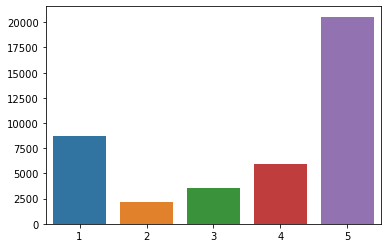

In [6]:
sns.barplot(x = np.unique(data_cat["label"]),
             y = [list(data_cat["label"]).count(i) for i in np.unique(data_cat["label"])] )

<AxesSubplot:>

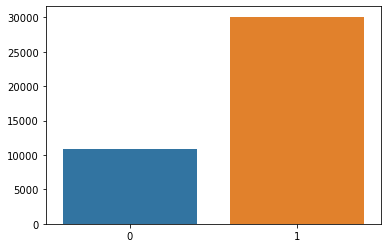

In [7]:
sns.barplot(x = np.unique(data_bin["label"]), 
             y = [list(data_bin["label"]).count(i) for i in np.unique(data_bin["label"])])

Due to data imbalanced in 5 different rating categories , we will work on binary classification problem instead. The output will be 0 and 1 representing NOT HAPPY and HAPPY respectively .

### Word Cloud

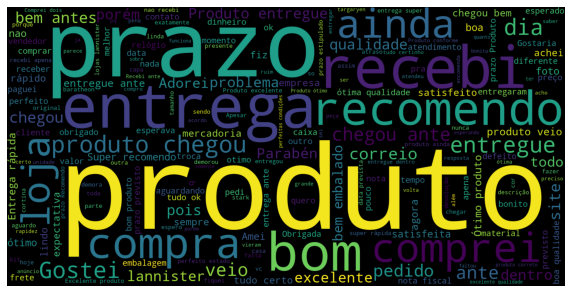

In [8]:
stop_words = stopwords.words('portuguese')
wordcloud = WordCloud(stopwords=stop_words,
                      background_color="black",
                      width=1600, height=800).generate(' '.join(data_bin["text"]))
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud);                            

### Spliting Data to training and test set

In [9]:
def split_test_train(data, split_train=TRAIN_SPLIT, random_state=RANDOM_STATE):
    df_train = data.sample(frac = split_train, random_state = random_state)
    df_test = data.drop(df_train.index)

    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    for index, train in df_train.iterrows():
        X_train.append(str(train['text']))
        y_train.append(train['label'])
    
    for index, test in df_test.iterrows():
        X_test.append(str(test['text']))
        y_test.append(test['label'])
        
    y_train = np.array(y_train)
    y_test = np.array(y_test) 
    
    return X_train , y_train , X_test , y_test

X_train , y_train , X_test , y_test = split_test_train(data_bin, split_train=TRAIN_SPLIT, random_state=RANDOM_STATE)

## Pre-Process

In [10]:
tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token=OOV_TOK)
tokenizer.fit_on_texts(X_train)

def preprocess(X_train, X_test, max_length, vocab_size, trunc_type='post', oov_tok = "<OOV>"):

    training_sequences = tokenizer.texts_to_sequences(X_train)
    X_train_padded = pad_sequences(training_sequences,maxlen=max_length, truncating=trunc_type)
    
    testing_sequences = tokenizer.texts_to_sequences(X_test)
    X_test_padded = pad_sequences(testing_sequences,maxlen=max_length)
    
    return X_train_padded, X_test_padded

X_train, X_test = preprocess(X_train, X_test, MAX_LENGTH, VOCAB_SIZE)

## NN MODEL

In [11]:
def create_model():
    
    input = tf.keras.Input(shape=(MAX_LENGTH))
    
    x = tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH)(input)
    x = tf.keras.layers.LSTM(32, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(32)(x)
    x = tf.keras.layers.Dropout(DROPOUT_P)(x)
    
    x = tf.keras.layers.Dense(800, activation='relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_P)(x)
    x = tf.keras.layers.Dense(400, activation='relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_P)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(input, output)

    return model

In [12]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

model = create_model()

model.compile(
  loss = tf.keras.losses.BinaryCrossentropy(),
  optimizer= tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE , momentum=MOMENTUM),
  metrics=['accuracy']
)

history = model.fit(x = X_train,
                    y = y_train, 
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks= [earlyStoppingCallback]
)

history = pd.DataFrame(history.history)

Train on 32782 samples, validate on 8195 samples
Epoch 1/25
32782/32782 [==============================] - 11s 335us/sample - loss: 0.5808 - accuracy: 0.7351 - val_loss: 0.5572 - val_accuracy: 0.7307
Epoch 2/25
32782/32782 [==============================] - 5s 141us/sample - loss: 0.5219 - accuracy: 0.7417 - val_loss: 0.5021 - val_accuracy: 0.7608
Epoch 3/25
32782/32782 [==============================] - 5s 141us/sample - loss: 0.4749 - accuracy: 0.7769 - val_loss: 0.3975 - val_accuracy: 0.8216
Epoch 4/25
32782/32782 [==============================] - 5s 160us/sample - loss: 0.3735 - accuracy: 0.8290 - val_loss: 0.3293 - val_accuracy: 0.8516
Epoch 5/25
32782/32782 [==============================] - 5s 146us/sample - loss: 0.3330 - accuracy: 0.8537 - val_loss: 0.3167 - val_accuracy: 0.8599
Epoch 6/25
32782/32782 [==============================] - 5s 151us/sample - loss: 0.3198 - accuracy: 0.8587 - val_loss: 0.3718 - val_accuracy: 0.8550
Epoch 7/25
32782/32782 [==========================

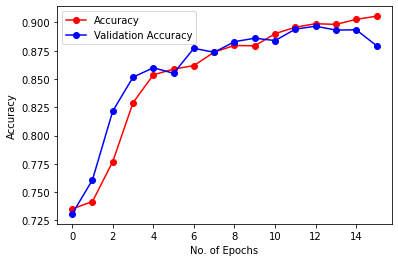

In [13]:
plt.plot(history["accuracy"] , label = "Accuracy" ,color = 'r'  , marker = 'o')
plt.plot(history["val_accuracy"] , label = "Validation Accuracy",color = 'b'  , marker = 'o')
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.legend()

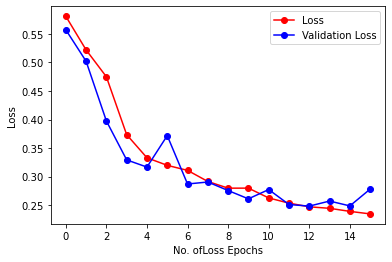

In [14]:
plt.plot(history["loss"] , label = "Loss", color = 'r'  , marker = 'o')
plt.plot(history["val_loss"] , label = "Validation Loss" ,color = 'b'  , marker = 'o')
plt.xlabel("No. ofLoss Epochs")
plt.ylabel("Loss")
plt.legend()

### Accuracy

In [15]:
y_preds_prob = model.predict(X_test, verbose=0)
y_preds = np.where(y_preds_prob> 0.5, 1, 0)
y_preds_prob = y_preds_prob[:, 0]
y_preds = y_preds[:, 0]

[loss,accuracy] = model.evaluate(X_test, y_test ,verbose = 0 )
print("Accuracy on Test Data :", accuracy*100 ,"%")


Accuracy on Test Data : 89.66442942619324 %


### Confusion Matrix

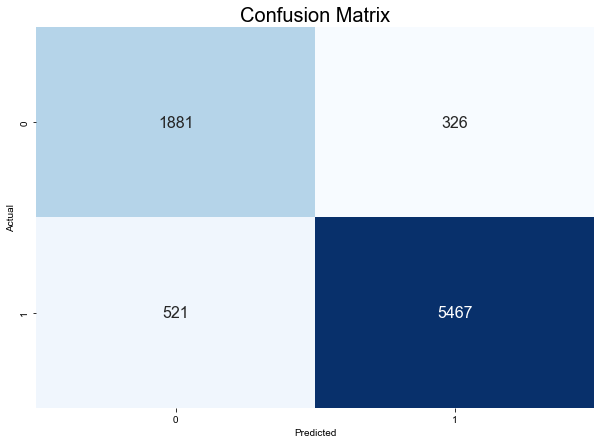

In [16]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=[0,1], index = [0,1])
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
plt.title('Confusion Matrix', fontsize = 20)

sns.set(font_scale=1.4)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

### Classification Report

In [17]:
print(classification_report(y_test ,y_preds))

              precision    recall  f1-score   support

           0       0.78      0.85      0.82      2207
           1       0.94      0.91      0.93      5988

    accuracy                           0.90      8195
   macro avg       0.86      0.88      0.87      8195
weighted avg       0.90      0.90      0.90      8195



### ROC AUC CURVE

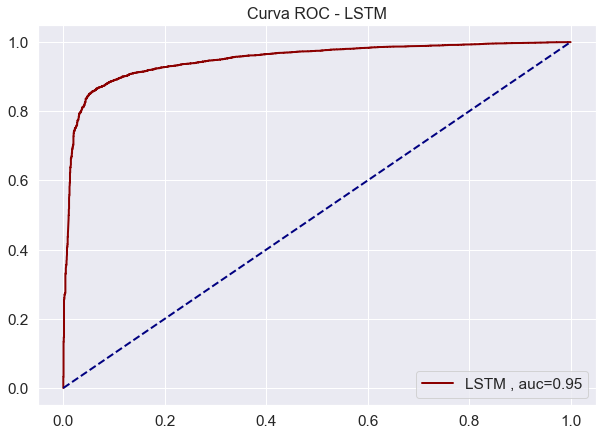

In [18]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds  = roc_curve(y_test, y_preds_prob)
auc = roc_auc_score(y_test, y_preds_prob)
plt.figure(figsize = (10,7))
plt.plot(fpr,tpr,color='darkred', lw=2, label="LSTM , auc="+str(round(auc,2)))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Curva ROC - LSTM', fontsize = 16)
plt.legend(loc=4)
plt.show()


# Comparison with differnt Classifiers

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## Logistic Regression

In [20]:
lr = LogisticRegression(max_iter= MAX_ITER,random_state=RANDOM_STATE, n_jobs= N_JOBS)
lr.fit(X_train,y_train)
lr_preds = lr.predict(X_test)
print("Model score on Training Data = ", lr.score(X_train,y_train))
print("Model score on Testing Data = ", lr.score(X_test,y_test))

print("")
print("Classification Report:")

print(classification_report(y_test , lr_preds))

Model score on Training Data =  0.744920993227991
Model score on Testing Data =  0.7333740085417938

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.09      0.15      2207
           1       0.74      0.97      0.84      5988

    accuracy                           0.73      8195
   macro avg       0.64      0.53      0.49      8195
weighted avg       0.69      0.73      0.65      8195



## Naive Bayes

In [21]:
nb = MultinomialNB()
nb.fit(X_train,y_train)
nb_preds = nb.predict(X_test)
print("Model score on Training Data = ", nb.score(X_train,y_train))
print("Model score on Testing Data = ", nb.score(X_test,y_test))
print("")
print("Classification Report:")

print(classification_report(y_test , nb_preds))

Model score on Training Data =  0.7455615886767128
Model score on Testing Data =  0.7435021354484441

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.37      0.44      2207
           1       0.79      0.88      0.83      5988

    accuracy                           0.74      8195
   macro avg       0.66      0.63      0.64      8195
weighted avg       0.72      0.74      0.73      8195



## Support Vector Machine (SVM)

In [22]:
svm = SVC(random_state=RANDOM_STATE , verbose = True)
svm.fit(X_train,y_train)
sv_preds = svm.predict(X_test)
print("Model score on Training Data = ", svm.score(X_train,y_train))
print("Model score on Testing Data = ", svm.score(X_test,y_test))
print("")
print("Classification Report:")

print(classification_report(y_test , sv_preds))

[LibSVM]Model score on Training Data =  0.797907388200842
Model score on Testing Data =  0.7449664429530202

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.21      0.30      2207
           1       0.76      0.94      0.84      5988

    accuracy                           0.74      8195
   macro avg       0.67      0.57      0.57      8195
weighted avg       0.71      0.74      0.70      8195



## RandomForest Classifier 

In [23]:
rfc = RandomForestClassifier(n_estimators = 100, random_state =RANDOM_STATE , n_jobs = N_JOBS)
rfc.fit(X_train,y_train)
rf_preds = rfc.predict(X_test)
print("Model score on Training Data = ", rfc.score(X_train,y_train))
print("Model score on Testing Data = ", rfc.score(X_test,y_test))
print("")
print("Classification Report:")

print(classification_report(y_test , rf_preds))

Model score on Training Data =  0.995790372765542
Model score on Testing Data =  0.7840146430750458

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.43      0.52      2207
           1       0.81      0.91      0.86      5988

    accuracy                           0.78      8195
   macro avg       0.73      0.67      0.69      8195
weighted avg       0.77      0.78      0.77      8195



## XGBoost Classifier

In [24]:
xgb = XGBClassifier(objective='binary:logistic' , 
                    use_label_encoder=False,  
                    random_state = RANDOM_STATE,
                    eval_metric='mlogloss')
xgb.fit(X_train,y_train)
xg_preds = xgb.predict(X_test)
print("Model score on Training Data = ", xgb.score(X_train,y_train))
print("Model score on Testing Data = ", xgb.score(X_test,y_test))
print("")
print("Classification Report:")

print(classification_report(y_test , xg_preds))

Model score on Training Data =  0.9296870233664816
Model score on Testing Data =  0.8301403294691885

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.60      0.66      2207
           1       0.86      0.91      0.89      5988

    accuracy                           0.83      8195
   macro avg       0.79      0.76      0.77      8195
weighted avg       0.82      0.83      0.83      8195



# Metrics Comparison on all 6 Models

## Accuracy

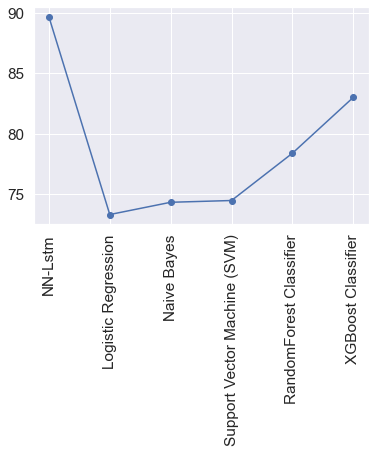

In [25]:
results = pd.DataFrame(data  = [accuracy*100] , columns =["NN-Lstm"] , index = ["Test Accuracy"])
results['Logistic Regression'] = lr.score(X_test,y_test)*100
results['Naive Bayes'] = nb.score(X_test,y_test)*100
results['Support Vector Machine (SVM)'] = svm.score(X_test,y_test)*100
results['RandomForest Classifier'] = rfc.score(X_test,y_test)*100
results['XGBoost Classifier'] = xgb.score(X_test,y_test)*100
results = results.transpose()
results
plt.plot(results["Test Accuracy"], color = 'b'  , marker = 'o')
plt.xticks(rotation='vertical');

## Confusion Matrix Comparison

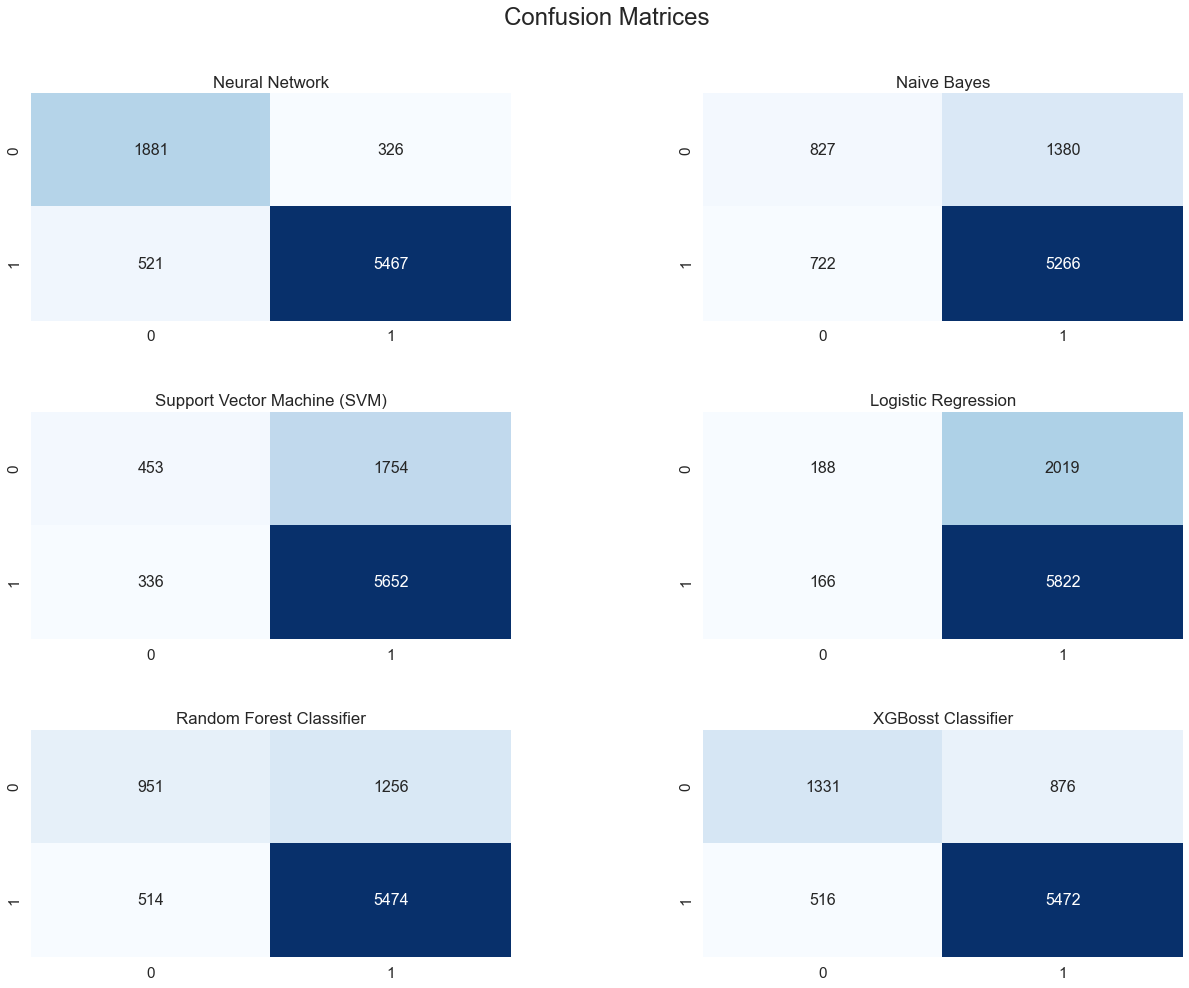

In [26]:
lr_cm=confusion_matrix(y_test, lr_preds )
nb_cm=confusion_matrix(y_test, nb_preds)
svm_cm=confusion_matrix(y_test, sv_preds)
nn_cm= confusion_matrix(y_test,y_preds)
rf_cm = confusion_matrix(y_test,rf_preds)
xg_cm = confusion_matrix(y_test,xg_preds)

plt.figure(figsize=(20,15))
plt.suptitle("Confusion Matrices",fontsize=24)

plt.subplot(3,2,1)
plt.title("Neural Network")
sns.heatmap(nn_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');


plt.subplot(3,2,2)
plt.title("Naive Bayes")
sns.heatmap(nb_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(3,2,3)
plt.title("Support Vector Machine (SVM)")
sns.heatmap(svm_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(3,2,4)
plt.title("Logistic Regression")
sns.heatmap(lr_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(3,2,5)
plt.title("Random Forest Classifier")
sns.heatmap(rf_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(3,2,6)
plt.title("XGBosst Classifier")
sns.heatmap(xg_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

## ROC_AUC Curve Comparison

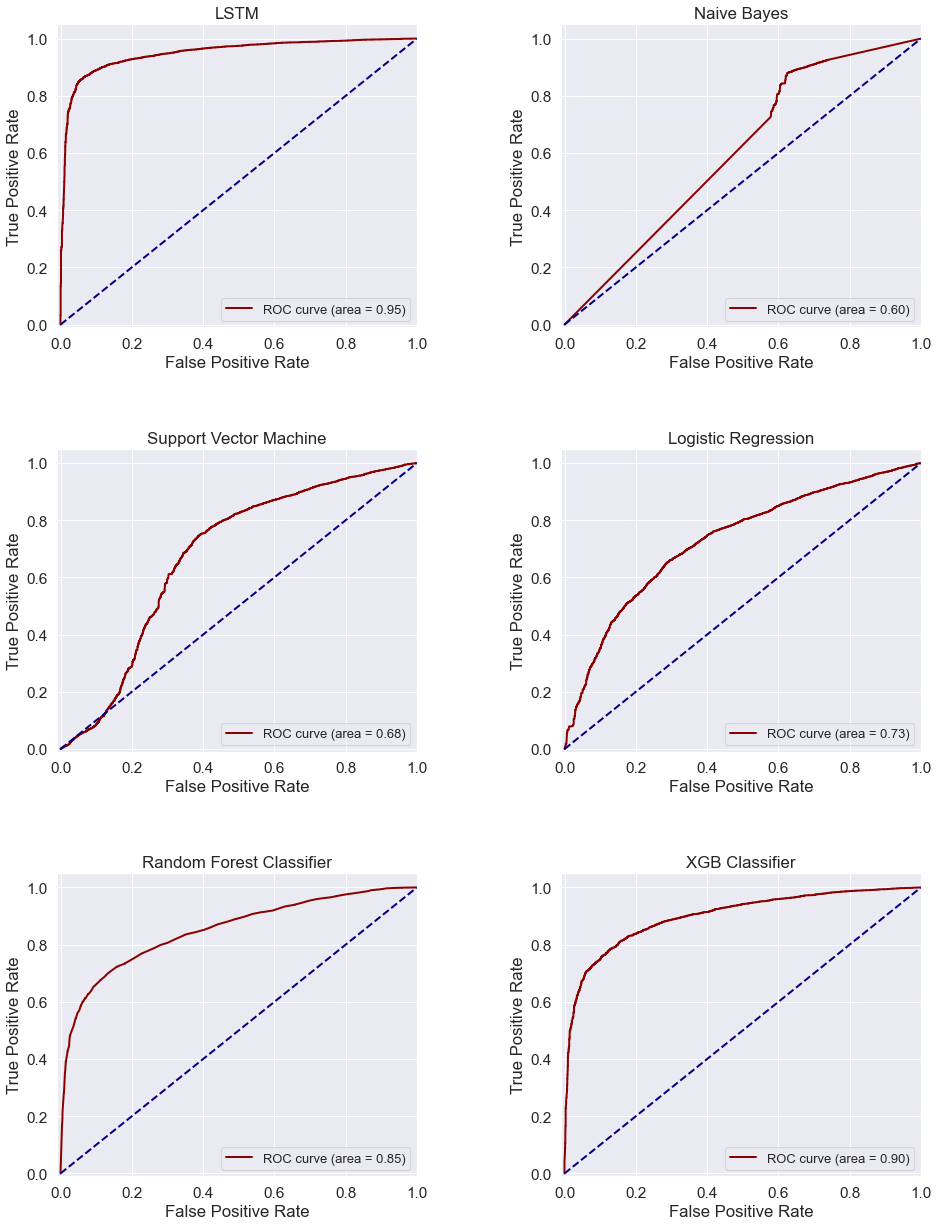

In [27]:
from sklearn.metrics import auc
pred_lr = lr.predict_proba(X_test)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(y_test,pred_lr)
roc_auc_lr = auc(fpr_lr,tpr_lr)

pred_nb = nb.predict_proba(X_test)[:,1]
fpr_nb,tpr_nb,_ = roc_curve(y_test,pred_nb)
roc_auc_nb = auc(fpr_nb,tpr_nb)

pred_svm = svm.decision_function(X_test)
fpr_svm,tpr_svm,_ = roc_curve(y_test,pred_svm)
roc_auc_svm = auc(fpr_svm,tpr_svm)

fpr_nn, tpr_nn, _  = roc_curve(y_test, y_preds_prob)
roc_auc_nn = auc(fpr_nn,tpr_nn)

pred_rf = rfc.predict_proba(X_test)[:,1]
fpr_rf,tpr_rf,_ = roc_curve(y_test,pred_rf)
roc_auc_rf = auc(fpr_rf,tpr_rf)

pred_xg = xgb.predict_proba(X_test)[:,1]
fpr_xg,tpr_xg,_ = roc_curve(y_test,pred_xg)
roc_auc_xg = auc(fpr_xg,tpr_xg)

f, axes = plt.subplots(3,2,figsize=(15,20))
axes[0,0].plot(fpr_nn, tpr_nn, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_nn))
axes[0,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'LSTM')
axes[0,0].legend(loc='lower right', fontsize=13);


axes[0,1].plot(fpr_nb, tpr_nb, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_nb))
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Naive Bayes')
axes[0,1].legend(loc='lower right', fontsize=13)

axes[1,0].plot(fpr_svm, tpr_svm, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_svm))
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Support Vector Machine')
axes[1,0].legend(loc='lower right', fontsize=13)

axes[1,1].plot(fpr_lr, tpr_lr, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_lr))
axes[1,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Logistic Regression')
axes[1,1].legend(loc='lower right', fontsize=13)


axes[2,0].plot(fpr_rf, tpr_rf, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_rf))
axes[2,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[2,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[2,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Random Forest Classifier')
axes[2,0].legend(loc='lower right', fontsize=13);


axes[2,1].plot(fpr_xg, tpr_xg, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_xg))
axes[2,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[2,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[2,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'XGB Classifier')
axes[2,1].legend(loc='lower right', fontsize=13);


plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)